Importing all relevant libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
%matplotlib inline

# import DBSCAN and Nearesr Neighbors from sklearn
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Details for Foursquare

In [2]:
CLIENT_ID = 'A0SGXE0HY11MZF32LUWRYCIAVV4RXG1I2GDBWJQTP3PP0NF5' # your Foursquare ID
CLIENT_SECRET = '3KKVCKW1CJGCBCIGIIP5RAJJFK3HYD4PFZJ50MBPE14PYEFN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A0SGXE0HY11MZF32LUWRYCIAVV4RXG1I2GDBWJQTP3PP0NF5
CLIENT_SECRET:3KKVCKW1CJGCBCIGIIP5RAJJFK3HYD4PFZJ50MBPE14PYEFN


Getting the data for Dhaka:

In [3]:
#location of Dhaka
latitude = 23.8103
longitude = 90.4125

In [4]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=A0SGXE0HY11MZF32LUWRYCIAVV4RXG1I2GDBWJQTP3PP0NF5&client_secret=3KKVCKW1CJGCBCIGIIP5RAJJFK3HYD4PFZJ50MBPE14PYEFN&v=20180605&ll=23.8103,90.4125&limit=200'

In [5]:
results = requests.get(url).json()

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Soi 71,Thai Restaurant,23.804539,90.413471
1,Tabaq,Coffee Shop,23.812956,90.423879
2,Lobby of Radisson,Hotel Bar,23.816966,90.407251
3,Holey Artisan Bakery,Bakery,23.802537,90.416710
4,Burger Lab,Burger Joint,23.812615,90.424544


In [8]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

83 venues were returned by Foursquare.


In [9]:
df=nearby_venues[['lng','lat']]

In [10]:
Arr=df.to_numpy()

Trying to find the "knee" for dbscan using some code from github. source linked below.

In [11]:
class DB_SCAN:
    model = 0 #The algorithm model
    training_set = []
    n_trainingData = 0 #Amount of training data evaluated using KNNdistPlot
    clustered_data = []
    labels = 0 #Array containing the labels of every point on the plane
    n_clusters = 0 #Number of clusters
    object_name = "nil"
    predicted_length = 0 #The length of the block to be predicted
    
    def KNNdist_plot(self,points,minPts):
        """
        Calculate where the slope of the kNNdistPlot is higher than a user-defined
       value while plotting the K-NN distance with respect to the amount of 
       training data
       
       :param points: List containing the points you want to use
       :param minPts: Minimum number of points to be considered a cluster
       :return: The most optimal parameter-values i.e Knee point values
       """
        
        epsPlot = []
        current_distanceMean = previous_distanceMean = 0
        knee_value = knee_found = 0
    
        for i in range (0,len(points),5):
            current_distanceMean = self.Get_distanceMean(points[i:],minPts,previous_distanceMean)
            df = current_distanceMean - previous_distanceMean
            
            #print("x=" + str(i) + " , df=" + str(df))
            if (df > 0.02 and i > 1 and knee_found == 0):
                knee_value = current_distanceMean
                knee_found = 1
                self.n_trainingData = i
                #knee_x = i
                
            epsPlot.append( [i,current_distanceMean] )
            previous_distanceMean = current_distanceMean
        
        
        #Plot the kNNdistPlot
        for i in range(0, len(epsPlot)):
                    plt.scatter(epsPlot[i][0],epsPlot[i][1],c='r',s=3,marker='o')
        plt.axhline(y=knee_value, color='g', linestyle='-')
        plt.axvline(x=self.n_trainingData , color='g', linestyle='-')
        plt.title(self.object_name)
        plt.show()
        print("Knee value: x=" + str(self.n_trainingData) + " , y=" + str(knee_value))
        #tm.Plot(epsPlot)
        
        return knee_value
    
    def Get_distanceMean(self,points,minPts,previous_distanceMean):
        """
        Method used to calculate the mean of the neighbors distances
        
        :param points: List containing the training-points you want to use
        :param minPts: Minimum number of points to be considered a cluster
        :param previous_distanceMean: The previous mean of the distances
        :return: Average distance between the points
        """
        
        if (minPts < len(points)):
            nbrs = NearestNeighbors(n_neighbors=minPts).fit(points)
            distances, indices = nbrs.kneighbors(points)
            d_mean = distances.mean()
            return d_mean
        else:
            return previous_distanceMean

source: https://github.com/vincewide/ML_scheduler/blob/a9225d15dcbbbbfc3ffefa58560369cbf0f9f704/DBSCAN.py

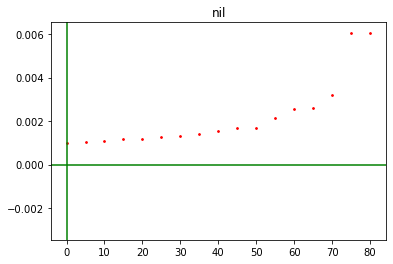

Knee value: x=0 , y=0


0

In [12]:
p= DB_SCAN()
knee=p.KNNdist_plot(points=Arr,minPts=3)
knee

Apparently there is no clear knee in the data. Will be using "try and error" method.

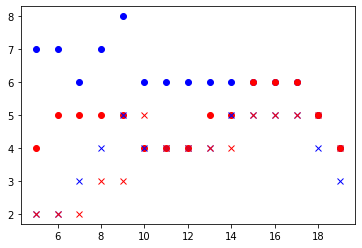

In [13]:
#checking out different values for eps and min_samples
dot = { 3: "bo", 
        4: "ro", 
        5: "bx",
        6: "rx"}

for i in range(5,20):
    for j in range(3,7):
        dbt = DBSCAN(eps=0.0001*i, min_samples=j).fit(Arr)
        labels = dbt.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        plt.plot(i,n_clusters_,dot[j])
    

Tried some of the combinations with larger number of clusters and finalized this version: <br>
(Note that k=0.0017  corresponds to a weak knee in the knn graph)

In [14]:
db = DBSCAN(eps=0.0017, min_samples=3).fit(Arr) #created a db from lat and lng

In [15]:
labels = db.labels_
labels

array([ 0,  1,  2, -1,  1,  0,  3,  0,  0,  4,  4,  4,  4,  5,  2,  3, -1,
       -1,  5,  4,  4,  5,  3,  5, -1,  5,  5, -1,  2,  5, -1,  5,  4,  5,
       -1, -1, -1, -1,  5,  5, -1,  5,  5,  2,  1,  5, -1, -1,  4,  5,  2,
        4,  5,  1,  3, -1,  1,  1,  2,  5, -1, -1,  2, -1,  1,  5,  4,  2,
        2,  2,  2,  2, -1,  3,  2, -1,  3,  3,  4,  1, -1, -1, -1])

In [16]:
nearby_venues['labels']=labels #appended the class to the dataframe

nearby_venues.head()

,name,categories,lat,lng,labels
0,Soi 71,Thai Restaurant,23.804539,90.413471,0
1,Tabaq,Coffee Shop,23.812956,90.423879,1
2,Lobby of Radisson,Hotel Bar,23.816966,90.407251,2
3,Holey Artisan Bakery,Bakery,23.802537,90.416710,-1
4,Burger Lab,Burger Joint,23.812615,90.424544,1


In [17]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

6

In [18]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2, 3, 4, 5}

In [19]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

color = colors.tolist()

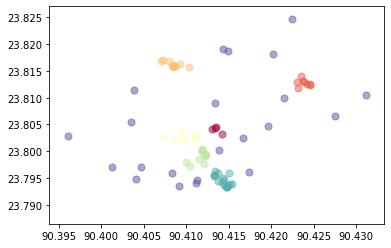

In [20]:
k=nearby_venues.apply(lambda row:plt.scatter(row["lng"], row["lat"], s=50,
                                             c=[color[row['labels']]], 
                                             marker=u'o', alpha=0.5 ),
                      axis=1)

In [21]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

#list of colors for folium
foliumcolor= ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 
              'lightblue', 'lightgreen', 'black', 'lightgray', 'gray']

# Plot the points with colors, on map
nearby_venues.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lng"]],
                                                   radius=5, 
                                                   color=foliumcolor[row['labels']], 
                                                   fill=True, 
                                                   fill_color=foliumcolor[row['labels']], 
                                                   fill_opacity=0.7)
                                                    .add_to(map_clusters), 
                    axis=1)


map_clusters.save('map.html')
map_clusters

Now we'll determine the center of each cluster

In [22]:
labeled = nearby_venues.groupby(['labels'], as_index=False).mean()
labeled = labeled[labeled.labels != -1]  #remove the mean of outlier data
labeled

,labels,lat,lng
1,0,23.804067,90.413551
2,1,23.812804,90.423819
3,2,23.816163,90.408472
4,3,23.802651,90.409774
5,4,23.799099,90.411663
6,5,23.794525,90.414312


In [23]:
#create map
map_cluster_centers = folium.Map(location=[latitude, longitude], zoom_start=14)

# Plot the points with colors, on map
labeled.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lng"]], 
                                             popup= 'Cluster '+str(int(row['labels']))+' center', 
                                             radius=5, 
                                             color=foliumcolor[int(row['labels'])], 
                                             fill=True, 
                                             fill_color=foliumcolor[int(row['labels'])], 
                                             fill_opacity=0.7)
                                                    .add_to(map_cluster_centers), 
                    axis=1)

map_cluster_centers

Now we'll plot the number of each type of venue, among all venues and in each cluster, and among the outliers

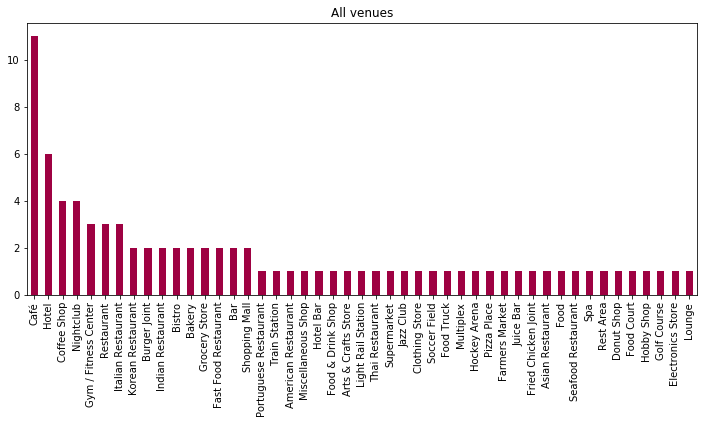

In [24]:
nearby_venues['categories'].value_counts().plot.bar(figsize=(12,5), colormap='Spectral', title= 'All venues')

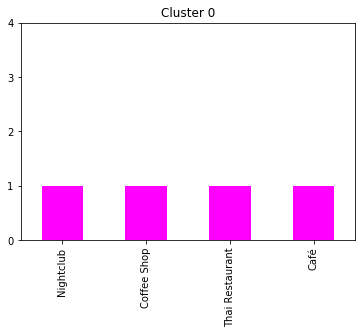

In [25]:
cluster0=nearby_venues[nearby_venues.labels==0]
cluster0['categories'].value_counts().plot.bar(colormap='spring', yticks=range(5), title= 'Cluster 0')

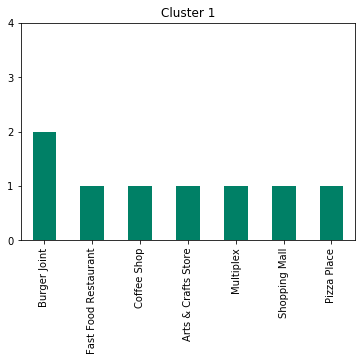

In [26]:
cluster1=nearby_venues[nearby_venues.labels==1]
cluster1['categories'].value_counts().plot.bar(colormap='summer', yticks=range(5), title= 'Cluster 1')

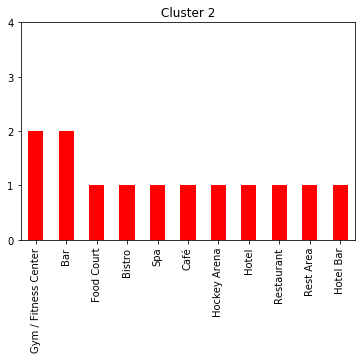

In [27]:
cluster2=nearby_venues[nearby_venues.labels==2]
cluster2['categories'].value_counts().plot.bar(colormap='autumn', yticks=range(5), title= 'Cluster 2')

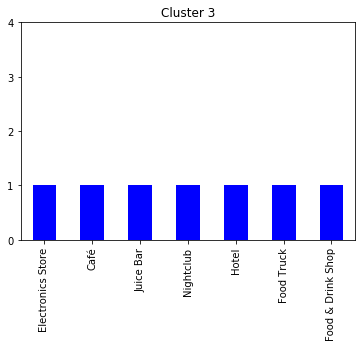

In [28]:
cluster3=nearby_venues[nearby_venues.labels==3]
cluster3['categories'].value_counts().plot.bar(colormap='winter', yticks=range(5), title= 'Cluster 3')

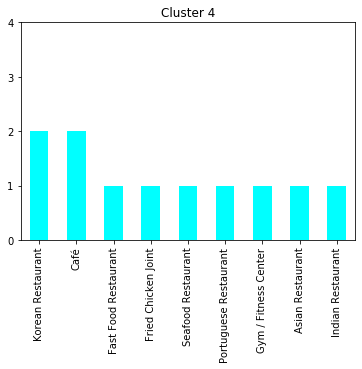

In [29]:
cluster4=nearby_venues[nearby_venues.labels==4]
cluster4['categories'].value_counts().plot.bar(colormap='cool', yticks=range(5), title= 'Cluster 4')

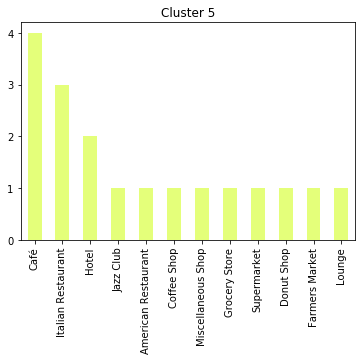

In [30]:
cluster5=nearby_venues[nearby_venues.labels==5]
cluster5['categories'].value_counts().plot.bar(colormap='Wistia', yticks=range(5), title= 'Cluster 5')

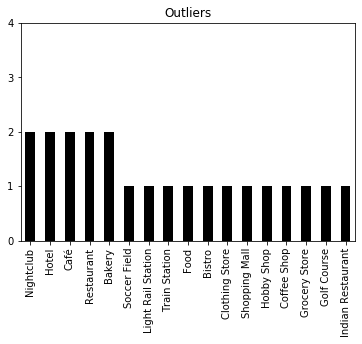

In [31]:
outliers=nearby_venues[nearby_venues.labels==-1]
outliers['categories'].value_counts().plot.bar(colormap='bone', yticks=range(5), title= 'Outliers')